# State Independent Bayesian Optimization: 
- Sina Dabiri 


In [9]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy
from sklearn.metrics import mean_squared_error

In [10]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [11]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        # U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO);
        trained_model_BaO.optimize(messages=False,max_f_eval = 1000);
        
        return trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [23]:
model = state_dr_gp()

In [44]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

# Balancing Anastesia and Awake samples
# input_data
U1_X0 = U1.join(X0_psd)

U1_X0_sel = U1_X0[0:n_used_samples]
X1_sel = X1[0:n_used_samples]

def apply_data_mask(U1_X0, X1):
    n_used_samples = 100; 
    scale = .1
    f_thresh = 25; g_thresh = 3
    U1_X0_sel = U1_X0[0:n_used_samples]
    X1_sel = np.squeeze(X1[0:n_used_samples])
    
    X1_thresh = np.squeeze(np.array(U1_X0_sel['sum_preStim_gamma'] > g_thresh, dtype = bool))
    # U1_thresh = U1_X0_sel['Stim_1'] > f_thresh
    sc= 1+scale*np.sin(np.array(U1_X0_sel.Stim_1)*0.1)*(1/(1+np.exp(-(np.array(U1_X0_sel['sum_preStim_gamma'])-2.5))))
    
    #X1_sel[X1_thresh] = np.multiply(X1_sel[X1_thresh],sc)
    X1_sel = np.multiply(X1_sel,sc)
    #display( np.multiply(X1_sel[X1_thresh],sc))
    X1_sel = X1_sel.reshape(-1,1)
    
    return U1_X0_sel, X1_sel


U1_X0_sel, X1_sel = apply_data_mask(U1_X0, X1)
display(U1_X0_sel)
display(np.shape(X1_sel))

NameError: name 'n_used_samples' is not defined

In [14]:
n_all_samples = np.shape(U1)[0]
n_burn_in = 20
n_samples= 150
n_acquisition = 100
n_parameters_optimizing = 2 # here we are optimizing freq. and amp.
n_all_parameters = 3 # freq amp and preStimGamma
n_exp_runs = 30
print(n_all_samples)

384


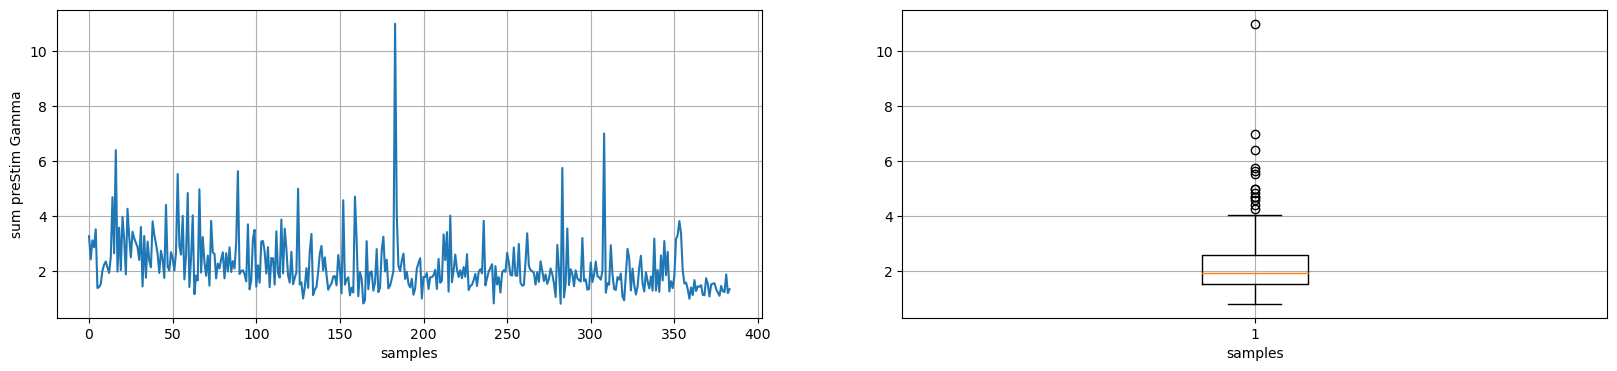

In [40]:


fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.plot(np.arange(0, n_all_samples), X0_psd['sum_preStim_gamma']);
plt.xlabel("samples")
plt.ylabel("sum preStim Gamma")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.boxplot(X0_psd['sum_preStim_gamma']);
plt.xlabel("samples")
plt.ylabel("")
plt.grid(visible=True)

plt.show();

In [19]:
hill_sum_preStim_gamma = np.empty((n_acquisition))
min_sum_preStim_gamma = np.min(X0_psd['sum_preStim_gamma'])
third_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.99)
# max_sum_preStim_gamma = np.max(X0_psd['sum_preStim_gamma'])
print("min preStimGamma is: \n", min_sum_preStim_gamma, " \n 3rd Quartile preStimGamma is:", 
      third_quartile_sum_preStim_gamma)
half_n_samples = int(n_acquisition/2)
step_size = np.round((third_quartile_sum_preStim_gamma-min_sum_preStim_gamma)/half_n_samples,6)
# hill_sum_preStim_gamma[0:half_n_samples] = np.arange(min_sum_preStim_gamma, third_quartile_sum_preStim_gamma, step_size)
# hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.arange(third_quartile_sum_preStim_gamma,
#                                                                      min_sum_preStim_gamma, -step_size)
hill_sum_preStim_gamma[0:half_n_samples] = np.linspace(min_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples)
hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.flip(np.linspace(min_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples))

print(hill_sum_preStim_gamma[0:3], np.shape(hill_sum_preStim_gamma))

min preStimGamma is: 
 0.8137995193089469  
 3rd Quartile preStimGamma is: 5.655506209786139
[0.81379952 0.91260986 1.0114202 ] (100,)


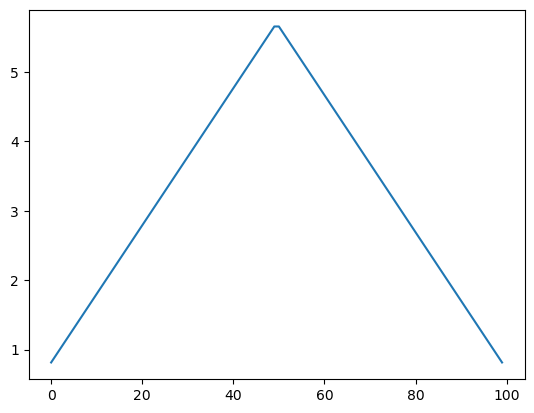

In [17]:
plt.plot(np.arange(0, n_acquisition), hill_sum_preStim_gamma);
#display((np.arange(min_sum_preStim_gamma, third_quartile_sum_preStim_gamma, step_size)))


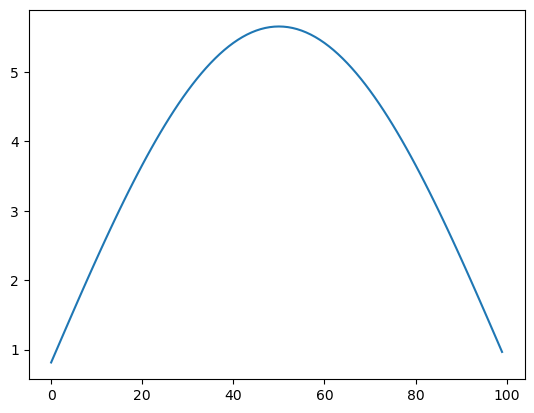

In [483]:
hill_sum_preStim_gamma = np.empty((n_acquisition))
min_sum_preStim_gamma = np.min(X0_psd['sum_preStim_gamma'])
third_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.99)

hill_sum_preStim_gamma = min_sum_preStim_gamma+(third_quartile_sum_preStim_gamma-min_sum_preStim_gamma)*np.sin(np.pi/n_acquisition*np.arange(0,n_acquisition))
plt.figure()
plt.plot(np.arange(0, n_acquisition), hill_sum_preStim_gamma);
plt.show()


In [16]:
print('freq and amplitude used are: \n', U1[0:4])




freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [17]:
U1.loc[0:10, 'Stim_1']



0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

In [18]:
print(np.shape(U1))

(384, 2)


## 1.2 First BaO Model is trained on all of the dataset

In [29]:
ker_BaO = GPy.kern.Matern52(input_dim=n_all_parameters, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [30]:
slice_dim = 1
ylabel='Predicted Gamma'



In [45]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

N_sel = 100

U1_X0_sel = U1_X0[1:N_sel]
X1_sel = X1[1:N_sel]

def apply_data_mask(U1_X0, X1):
    N_sel = 100; scale = .1
    f_thresh = 25; g_thresh = 3
    U1_X0_sel = U1_X0[1:N_sel]
    X1_sel = np.squeeze(X1[1:N_sel])
    
    X1_thresh = np.squeeze(np.array(U1_X0_sel['sum_preStim_gamma'] > g_thresh, dtype = bool))
    # U1_thresh = U1_X0_sel['Stim_1'] > f_thresh
    sc= 1+scale*np.sin(np.array(U1_X0_sel.Stim_1)*0.1)*(1/(1+np.exp(-(np.array(U1_X0_sel['sum_preStim_gamma'])-2.5))))
    
    #X1_sel[X1_thresh] = np.multiply(X1_sel[X1_thresh],sc)
    X1_sel = np.multiply(X1_sel,sc)
    #display( np.multiply(X1_sel[X1_thresh],sc))
    X1_sel = X1_sel.reshape(-1,1)
    
    return U1_X0_sel, X1_sel


U1_X0_sel, X1_sel = apply_data_mask(U1_X0, X1)
display(U1_X0_sel)
display(np.shape(X1_sel))
#display(np.concatenate((X1[1:N_sel],X1_sel), axis = 1))

,Stim_1,Stim_2,sum_preStim_gamma
1,42,40,2.425945
2,35,30,3.117866
3,23,50,2.868627
4,42,50,3.521665
5,35,50,1.384478
...,...,...,...
95,35,20,3.700448
96,17,20,1.337936
97,5,10,1.672055
98,17,30,3.179625


(99, 1)

#### 1.2.1: The first model uses sum_preStim_gamma.

 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f7dc88c68c0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f7dc88c6ce0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0006   6.239973e+02   1.048414e+03 
    00s12  0015   3.121874e+02   3.490643e-01 
    00s19  0022   2.991071e+02   1.295738e-01 
    00s24  0037   2.972559e+02   5.656004e-10 
Runtime:     00s24
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x7f7dc8980820>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f7dc8954f10>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f7dc74def50>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f7dc74df880>]}

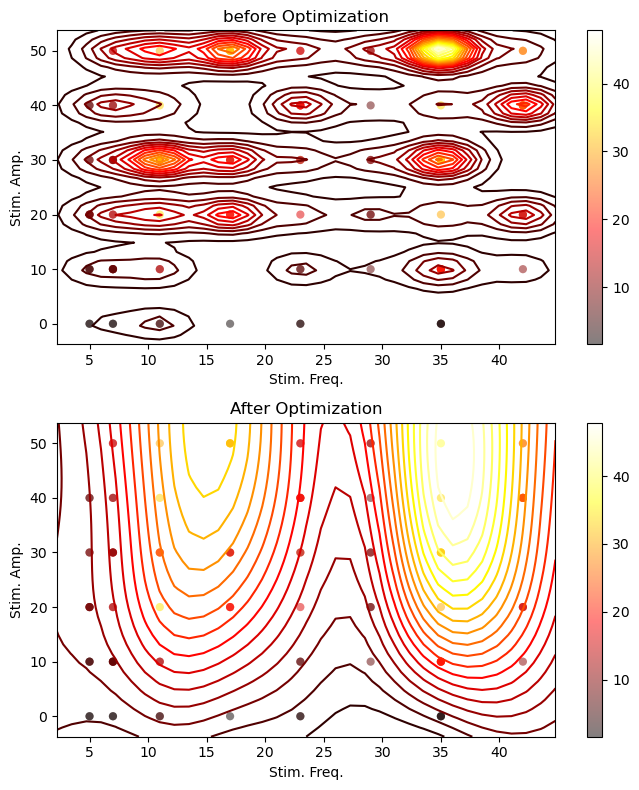

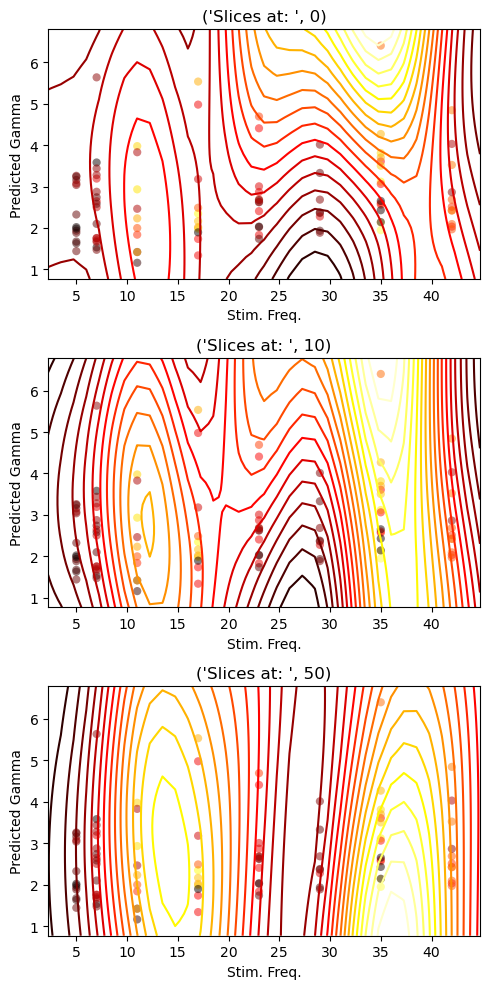

In [32]:
# x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

# input_data
#U1_X0 = U1.join(X0_psd)

# create simple GP model
trained_model_BaO = GPy.models.GPRegression(U1_X0_sel,X1_sel,ker_BaO)
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
              title="before Optimization");
display(canvas);
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax);

# optimize and plot
trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
canvas_optimized = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                title='After Optimization');
display(canvas_optimized)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));
    
    canvas_slices = trained_model_BaO.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas_slices);

In [207]:
display(np.shape(simY_BaO_AF))
display(np.unique(testX))
display(np.squeeze(np.asarray(X_grid_mesh[0])))

(2500, 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50])

array([[ 1,  2,  3, ..., 48, 49, 50],
       [ 1,  2,  3, ..., 48, 49, 50],
       [ 1,  2,  3, ..., 48, 49, 50],
       ...,
       [ 1,  2,  3, ..., 48, 49, 50],
       [ 1,  2,  3, ..., 48, 49, 50],
       [ 1,  2,  3, ..., 48, 49, 50]])

15.53123969935174

14.879009398687018

15.53123969935174

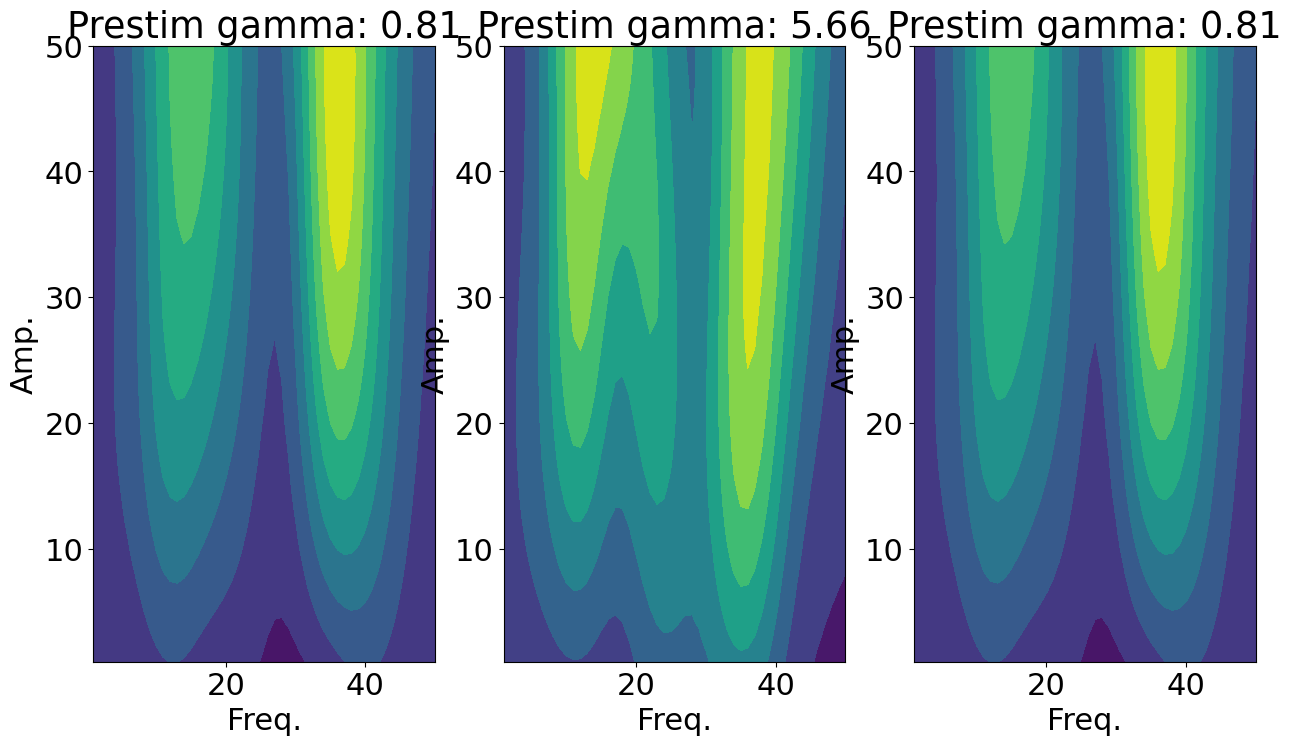

In [123]:
sim_optparam_test = np.full([len(hill_sum_preStim_gamma),2], np.nan)

#pts_surf = [0,24,49]
pts_surf = [0,50,99]

pts_to_plot = []

fig = plt.figure(figsize = (15,8))

X_grid1 = np.arange(1,51)
X_grid2 = np.arange(1,51)
X_grid_mesh = np.meshgrid(X_grid1, X_grid2)
X_grid = np.concatenate((np.asarray(X_grid_mesh[0]).reshape(-1,1), np.asarray(X_grid_mesh[1]).reshape(-1,1)),axis = 1)

counter = 1
for a in range(0, n_acquisition):
    
    # print("acquisition #: ", a)
    temp = np.full([len(X_grid),1], hill_sum_preStim_gamma[a])
    
    X_pred = np.concatenate((X_grid, temp), axis = 1)
    simY_BaO_AF = np.empty((1, n_samples))
    simMse_BaO_AF = np.empty((1, n_samples))
    simY_BaO_AF, simMse_BaO_AF= trained_model_BaO.predict(X_pred);
                             
    argMax_model = simY_BaO_AF.argmax()
    # sim_optparam_test[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
    sim_optparam_test[a,:] = X_grid[argMax_model]
    
    if a in pts_surf:
        #ax = fig.add_subplot(1,3,counter,projection='3d')
        ax = fig.add_subplot(1,3,counter)
        # data = pd.DataFrame(data={'x':X_pred[:,0], 'y':X_pred[:,1], 'z':np.squeeze(simY_BaO_AF)})
        # data = data.pivot(index='x', columns='y', values='z')
        # sns.heatmap(data)
        #ax.scatter(X_pred[:,0],X_pred[:,1],simY_BaO_AF)
        pts_to_plot.append(simY_BaO_AF)
        ax.contourf(X_grid1,X_grid2,np.reshape(simY_BaO_AF,(len(X_grid1),len(X_grid2))))
        plt.title(f"Prestim gamma: {'{0:.2f}'.format(hill_sum_preStim_gamma[a])}")
        plt.xlabel('Freq.')
        plt.ylabel('Amp.')
        counter = counter + 1
        
        display(np.mean(simY_BaO_AF))

plt.show()

In [121]:
display(pts_to_plot)

[array([[1.90443154],
        [1.93431024],
        [1.92705364],
        ...,
        [9.43987189],
        [7.72979479],
        [6.29579833]]),
 array([[1.77852206],
        [1.88465091],
        [1.98307755],
        ...,
        [9.73987295],
        [7.99418544],
        [6.51666124]]),
 array([[1.90443154],
        [1.93431024],
        [1.92705364],
        ...,
        [9.43987189],
        [7.72979479],
        [6.29579833]])]

array([[36., 48.],
       [36., 48.],
       [36., 48.],
       [36., 48.],
       [36., 47.],
       [36., 47.],
       [36., 47.],
       [36., 47.],
       [36., 47.],
       [36., 47.],
       [36., 47.],
       [36., 47.],
       [36., 47.],
       [36., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 47.],
       [37., 46.],
       [37., 46.],
       [37., 46.],
       [37., 46.],
       [14., 50.],
       [14., 50.],
       [14., 50.],
       [14., 50.],
       [14., 50.],
       [14., 50.],
       [14., 50.],
       [14., 50.],
       [14., 50.],
       [14., 50.],
       [14., 50.],
       [14.,

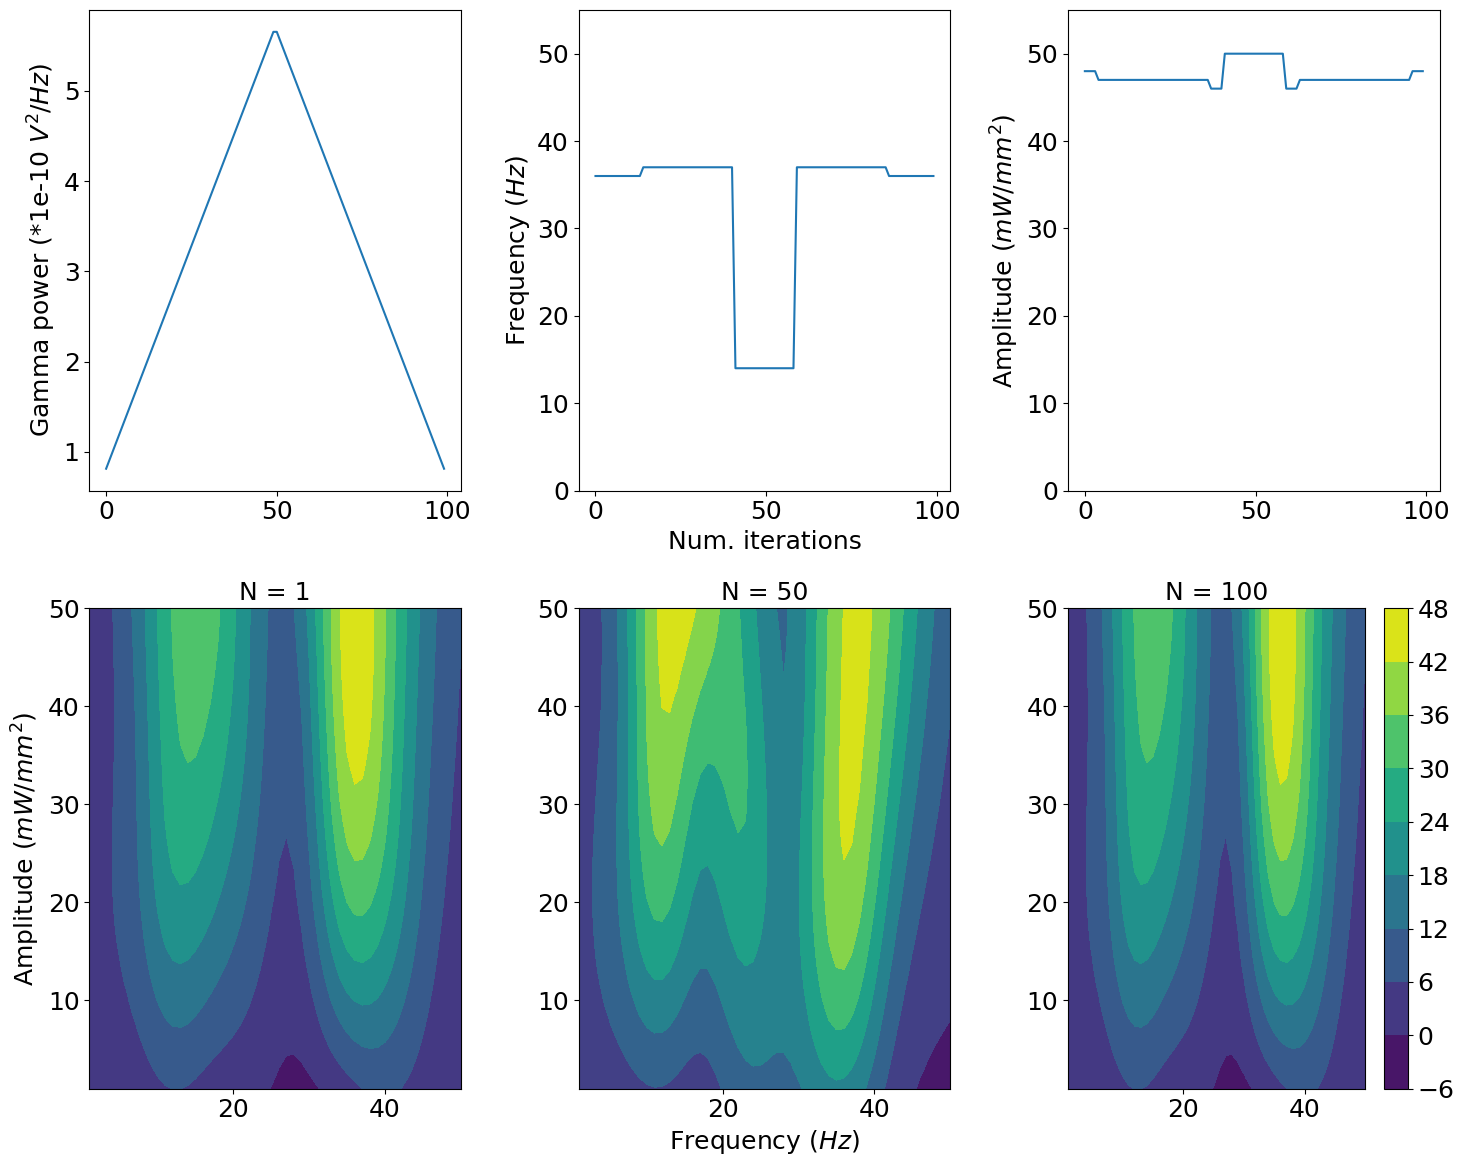

In [157]:
display(sim_optparam_test)
#display(np.where(sim_optparam_test[:,0]<25))

fsize = 18
fig = plt.figure(figsize = (15,12))
plt.subplot(2,3,1)
plt.plot(np.arange(0, n_acquisition), hill_sum_preStim_gamma);
plt.ylabel('Gamma power (*1e-10 $V^2/Hz$)')
plt.subplot(2,3,2)
plt.plot(sim_optparam_test[:,0])
plt.xlabel('Num. iterations')
plt.ylabel('Frequency ($Hz$)')
plt.ylim([0,55])
plt.subplot(2,3,3)
plt.plot(sim_optparam_test[:,1])
plt.ylabel('Amplitude ($mW/mm^2$)')
plt.ylim([0,55])

ax = plt.subplot(2,3,4)

ax.contourf(X_grid1,X_grid2,np.reshape(pts_to_plot[0],(len(X_grid1),len(X_grid2))))

plt.ylabel('Amplitude ($mW/mm^2$)')
plt.title('N = 1', fontsize = fsize)

ax = plt.subplot(2,3,5)
ax.contourf(X_grid1,X_grid2,np.reshape(pts_to_plot[1],(len(X_grid1),len(X_grid2))))
plt.xlabel('Frequency ($Hz$)')
plt.title('N = 50', fontsize = fsize)
ax = plt.subplot(2,3,6)
temp = ax.contourf(X_grid1,X_grid2,np.reshape(pts_to_plot[2],(len(X_grid1),len(X_grid2))))
plt.title('N = 100', fontsize = fsize)
fig.colorbar(temp)
fig.tight_layout()
plt.show()
         

In [ ]:
## 1.3: Train the Static model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp 

- The Static model does not use preStimGamma and brain state.
- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [50]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
# X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print( '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))


 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]] (20, 1)


In [17]:
# input_data
# U1_X0_init = U1_init.join(X0_psd_init)

In [32]:
print(type(U1_init),type(X1_init))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [33]:
ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0002   9.611651e+02   4.064185e+04 
    00s04  0004   4.852573e+02   3.345151e+03 
    00s06  0008   1.702266e+02   4.102541e+01 
    00s10  0013   8.225640e+01   2.768416e-02 
    00s19  0030   7.039212e+01   2.829998e-02 
    00s26  0058   6.946105e+01   2.104166e-11 
Runtime:     00s26
Optimization status: Converged



 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fc03553bd00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7fc03553bc10>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fc0359da770>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fc035a08d90>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fc035a08fd0>]}

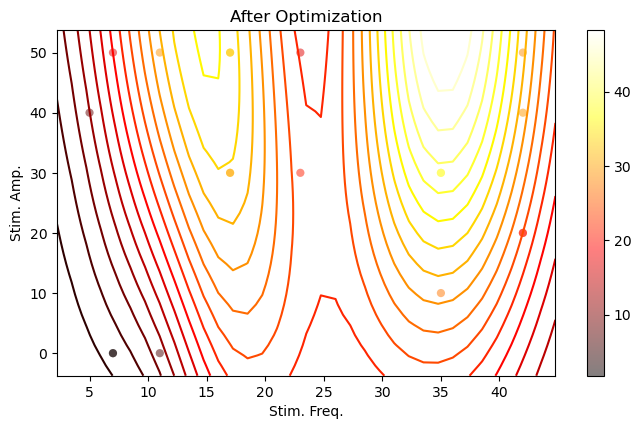

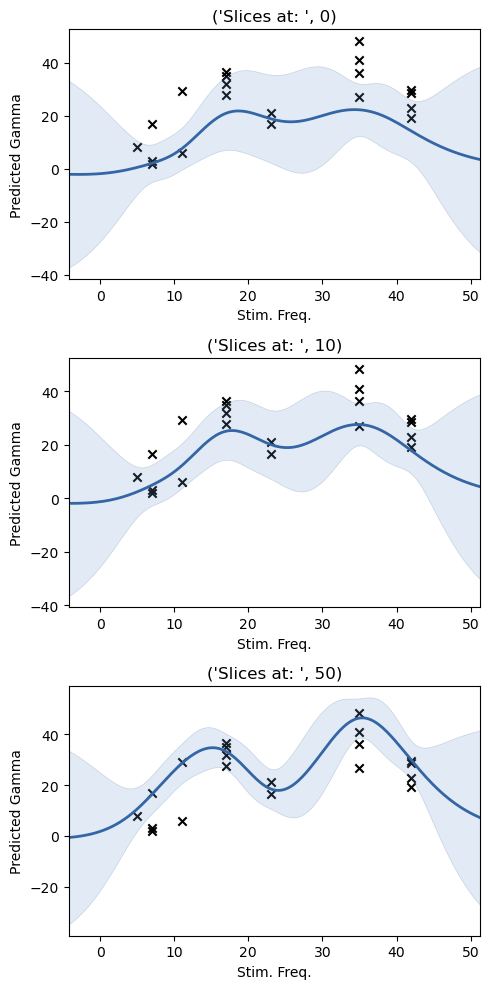

In [34]:
# x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_AF.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_AF.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [35]:
rand_freq_1d = np.random.choice(np.arange(1,43,1), size=(n_samples))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted)
rand_amp_1d = np.random.choice(np.arange(1,51,1), size=(n_samples))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))

[ 1  1  1  1  1  1  1  1  1  1  2  2  3  4  5  5  5  5  5  5  6  7  7  7
  7  7  7  8  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 12 12 12 12 13
 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 18 18 19 19 19 19 19 20 20
 20 20 20 20 20 20 21 21 21 21 21 21 22 22 22 23 23 24 24 24 25 25 25 25
 26 26 26 26 26 27 28 29 30 30 30 30 31 31 31 31 32 32 32 32 33 33 34 35
 35 36 36 36 37 37 37 38 38 38 38 39 39 39 39 40 40 40 40 40 40 40 41 41
 41 41 42 42 42 42]
[ 1  1  1  1  2  3  3  3  3  4  4  4  4  4  5  5  5  6  6  6  7  7  7  7
  7  7  8  8  8  8  8  9  9  9 10 11 11 12 12 12 12 12 12 12 13 13 13 14
 14 15 16 16 17 17 18 18 18 19 21 21 21 22 22 22 22 24 24 24 25 25 25 25
 25 26 26 26 27 27 27 27 28 28 28 28 28 29 30 30 31 31 31 31 32 32 32 32
 32 33 33 33 33 34 34 34 36 36 36 36 37 37 37 37 37 37 38 39 39 39 39 40
 40 41 41 41 41 41 42 43 43 43 43 44 44 45 45 46 46 46 46 46 46 46 47 47
 47 48 48 50 50 50] (150,)


In [36]:
print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(np.shape(testX))

(150,) (150,)
(2, 150)
(150, 2)


In [37]:
# Try passing in and out dictionaires:

static_dict = {'n_samples':n_samples, 'n_all_parameters':n_all_parameters, 'n_acquisition':n_acquisition, 
               'testX':testX, 'hill_sum_preStim_gamma':hill_sum_preStim_gamma, 'trained_model_BaO':trained_model_BaO, 
               'trained_model_BaO_AF':trained_model_BaO_AF, 'U1_init':U1_init, 'X1_init':X1_init, 'ker_BaO_AF':ker_BaO_AF}

In [47]:
def static_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, 
                     X1_init, ker_BaO_AF):

    # a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
    ucb = np.empty((1, n_samples))
    ucb_sample = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_static = np.empty((n_acquisition, 1))
    # print(np.shape(ucb))
    model_sample_static = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)

    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_AF = np.empty((1, n_samples))
        simMse_BaO_AF = np.empty((1, n_samples))
        simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);

        argMax_model = simY_BaO_AF.argmax()
        model_sample_static[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_static_reshaped = np.reshape(model_sample_static[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_static_reshaped)

        ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
        max_ucb = np.max(ucb, axis=0)
        argMax_ucb = ucb.argmax()
        # find the values of argMax_ucb in the sample grid
        ucb_sample[a,:] = np.append(testX[argMax_ucb],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,n_all_parameters))
        # print("Static model prediction: ", ucb_sample_reshaped)

        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation[a] = trained_model_BaO.posterior_samples_f(model_sample_static_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_static[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
        U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_static[a]]
        X1_init = np.append(X1_init, next_postStimGamma, axis=0)

        # trained_model_BaO_AF.add_observer()
        trained_model_BaO_AF = model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_AF);
    
    return trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static

In [457]:
trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static = static_BaO_func(
    n_samples, n_all_parameters, n_acquisition,X_grid , hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)

#### 1.3.3: Plot before and after optimization 

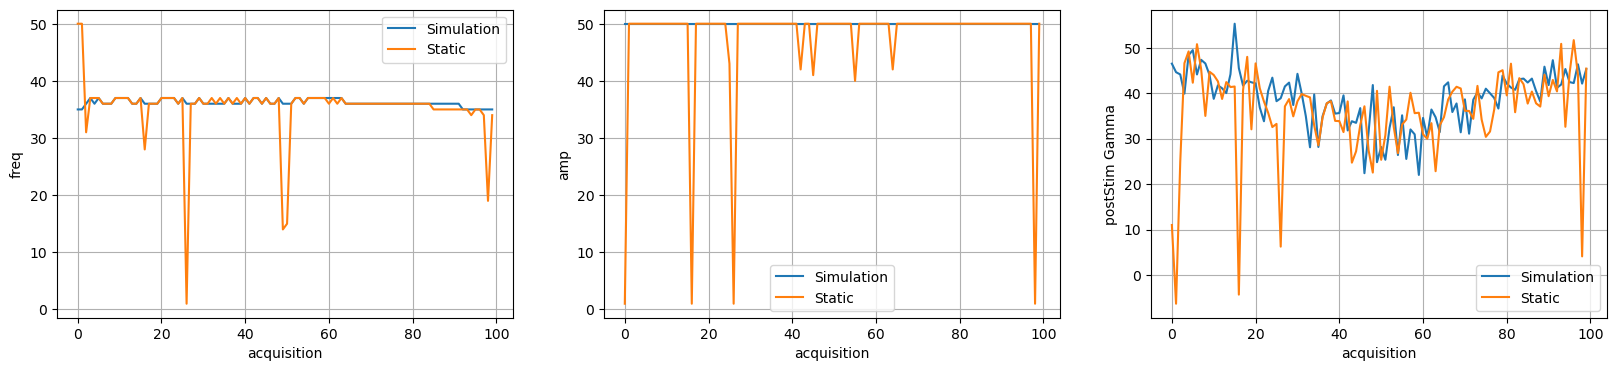

In [458]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_static, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)
plt.show();
# plot the model's max (freq, amp, postStim gamma) at each iteration

In [459]:
# print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])
# print(ucb_sample[1:,2])

[50. 31. 37. 37. 37. 36. 36. 36. 37. 37. 37. 37. 36. 36. 37. 28. 36. 36.
 36. 37. 37. 37. 37. 36. 37.  1. 36. 36. 37. 36. 36. 37. 36. 37. 36. 37.
 36. 37. 36. 37. 36. 37. 37. 36. 37. 36. 36. 37. 14. 15. 36. 37. 37. 36.
 37. 37. 37. 37. 37. 36. 37. 36. 37. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 34. 35. 35. 34. 19. 34.]
[50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.  1. 50. 50.
 50. 50. 50. 50. 50. 50. 43.  1. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 42. 50. 50. 41. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 40. 50. 50. 50. 50. 50. 50. 50. 50. 42. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50.  1. 50.]


In [460]:
print(postStimGamma_predicted_from_simulation_static[1:10])

[[-6.32058252]
 [24.86864059]
 [46.62159766]
 [49.21311799]
 [42.32501544]
 [50.79918245]
 [45.29334425]
 [35.01363697]
 [44.73759828]]


### 1.4: Dynamic BaO

In [53]:
dynamic_model = state_dr_gp()

In [54]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_dynamic, X1_dynamic, lower_bound, upper_bound, X0_psd_dynamic, N_trials = dynamic_model.gp_model(path)

#### 1.4.1: We will not use preStimGamma, and instead we will train on most recent 20 samples so the model is not affected by brain state changes.

In [55]:
U1_init_dynamic = U1_dynamic.loc[0:n_burn_in-1,:]
X1_init_dynamic = X1_dynamic[0:n_burn_in,:]
# X0_psd_init_dynamic = X0_psd.loc[0:n_burn_in-1]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
# print('Sum preStim gamma are: \n', X0_psd_init_dynamic)
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]] (20, 1)


In [462]:
ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [463]:
print(np.shape(U1_init_dynamic))
print(np.shape(X1_init_dynamic))
# print(np.shape(X0_psd_init_dynamic))

(20, 2)
(20, 1)


In [464]:
print(type(U1_init_dynamic),type(X1_init_dynamic))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


#### 1.4.2: Initial training of the Dynamic model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003   6.650130e+02   1.070147e+04 
    00s11  0011   8.975792e+01   2.859550e-01 
    00s12  0013   8.225640e+01   2.768416e-02 
    00s19  0029   7.477016e+01   1.096871e+01 
    00s36  0058   6.946105e+01   2.104166e-11 
Runtime:     00s36
Optimization status: Converged



 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fc02521eb00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7fc02521cd30>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fc04f1ea080>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fc04f1e9d50>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fc04f1ebe50>]}

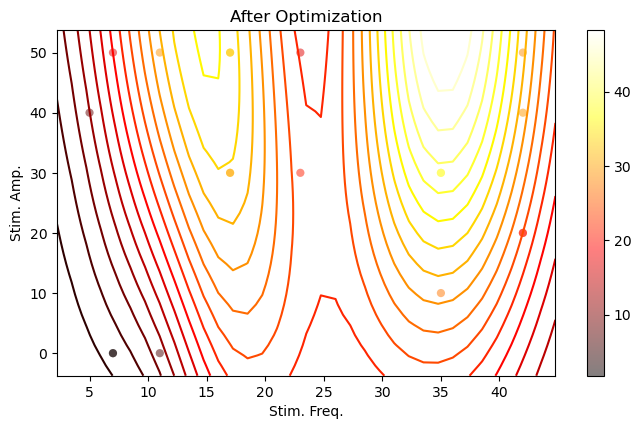

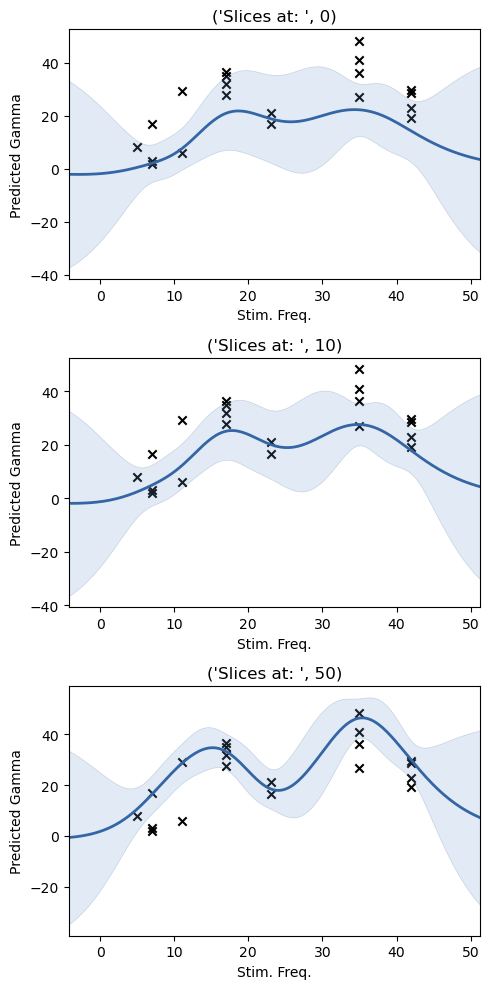

In [465]:
# Initialize a dynamic model:
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
#                                                                                                ker_BaO_dynamic, slice_dim, ylabel)
trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
# ker_BaO, slice_dim, ylabel)

In [410]:
print(np.shape(testX))

(150, 2)


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [48]:
def dynamic_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, 
                     X1_init_dynamic, ker_BaO_dynamic):
    
    ucb_dynamic = np.empty((1, n_samples))
    ucb_sample_dynamic = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_d = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_dynamic = np.empty((n_acquisition, 1))
    # print(np.shape(ucb_dynamic))
    model_sample_dynamic = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)

    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_dynamic = np.empty((1, n_samples))
        simMse_BaO_dynamic = np.empty((1, n_samples))
        simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX);

        argMax_model = simY_BaO_dynamic.argmax()
        model_sample_dynamic[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_dynamic_reshaped = np.reshape(model_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_dynamic_reshaped)    

        ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
        max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
        argMax_ucb_dynamic = ucb_dynamic.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_dynamic[a, :] = np.append(testX[argMax_ucb_dynamic],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Dynamic model prediction: ", ucb_sample_reshaped)
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_d[a] = trained_model_BaO.posterior_samples_f(model_sample_dynamic_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_dynamic[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # print(postStimGamma_predicted_from_simulation_dynamic[a])
        # simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
        U1_init_dynamic = pd.concat([U1_init_dynamic, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
        U1_init_dynamic_twenty = U1_init_dynamic.loc[a:a+int(n_burn_in-1),:]

    #     # sum_preStim_gamma
    #     next_preStimGamma_dynamic = pd.DataFrame({'sum_preStim_gamma':[int(ucb_sample_dynamic[a,2])]})
    #     X0_psd_init_dynamic = pd.concat([X0_psd_init_dynamic, next_preStimGamma_dynamic], ignore_index=True, axis=0)
    #     X0_psd_init_dynamic_twenty = X0_psd_init_dynamic.loc[a:a+int(n_burn_in),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_dynamic[a]]
        X1_init_dynamic = np.append(X1_init_dynamic, next_postStimGamma, axis=0)
        # print("X1_init_dynamic shape is: ", np.shape(X1_init_dynamic))

        X1_init_dynamic_twenty = X1_init_dynamic[a:a+int(n_burn_in),:]
        # print(np.shape(U1_init_dynamic_twenty),np.shape(X1_init_dynamic_twenty))
        # trained_model_BaO_AF.add_observer()
        # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
        trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_init_dynamic_twenty, X1_init_dynamic_twenty, ker_BaO_dynamic)
        
    return trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic
    

In [467]:
trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic = dynamic_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)

 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [468]:
# testX[argMax_ucb_dynamic]
print(np.shape(trained_model_BaO_Dynamic))

()


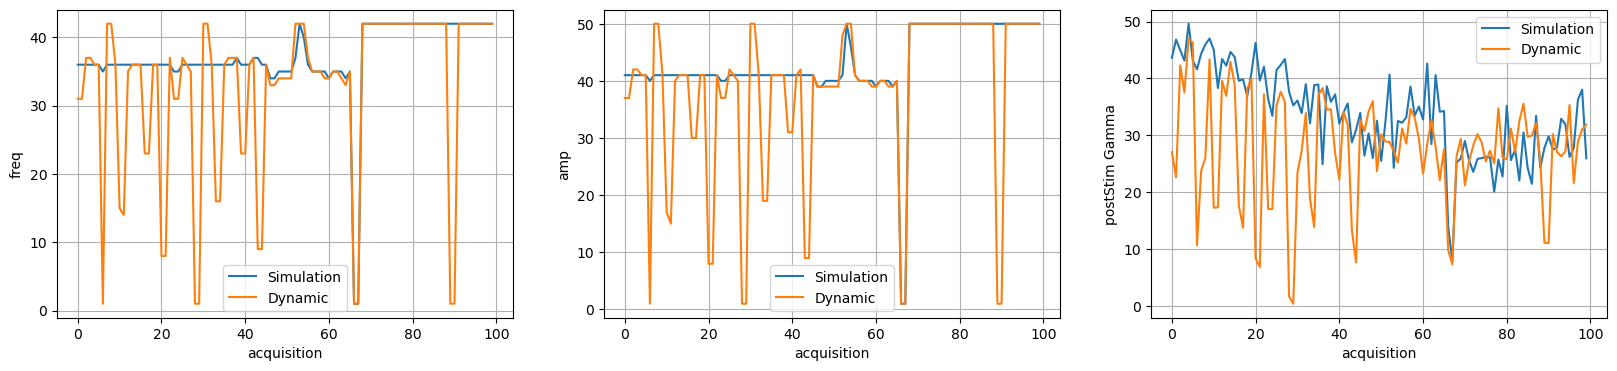

In [469]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[0:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[0:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_d, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_dynamic, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)
plt.show()

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fc0376788e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7fc03d3abd30>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fc04e7b5630>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fc04e7b5f00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fc04e7b7070>]}

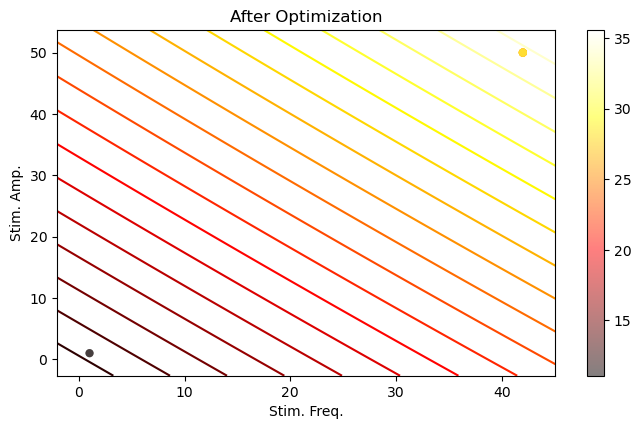

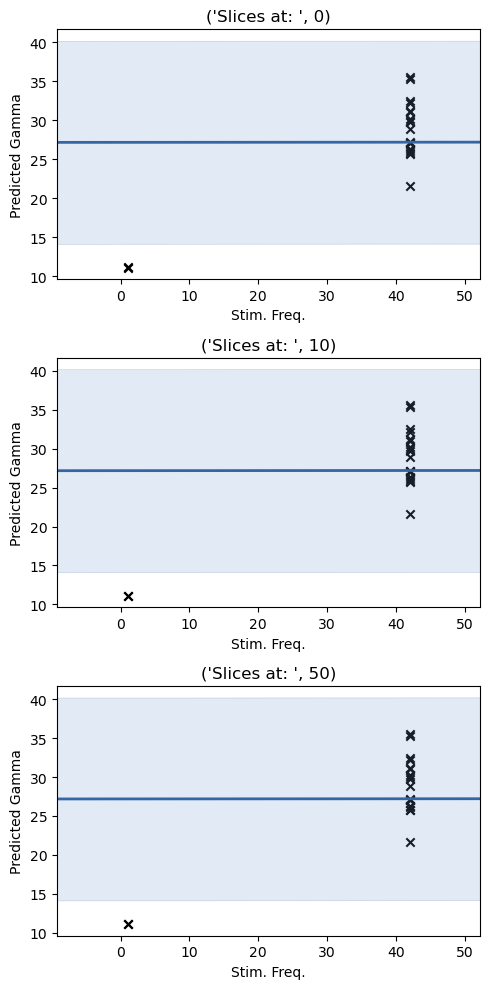

In [470]:
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

### 1.5: comparing static and dynamic BaO

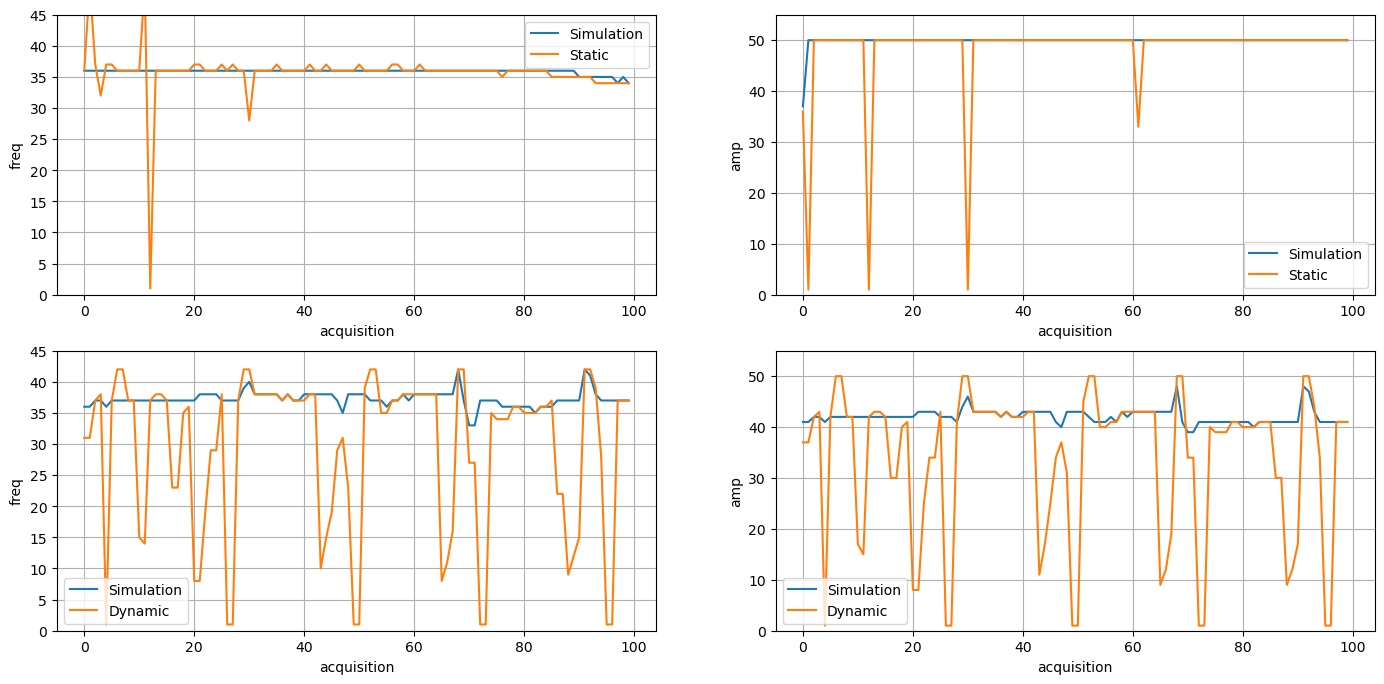

In [444]:
fig = plt.figure(figsize=(17,8));
fig.title = ("Simulation vs. Static/Dynamic BaO")
plt.subplot(2,2,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,3)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(2,2,4)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.show()


#### 1.5: Experiment Loop 

In [491]:
#print(np.shape(model_sample_static))
display(np.shape(static_sample))
display(np.shape(X_grid))

(100, 3, 30)

(2500, 2)

In [78]:
# Initialize variables:
# reshape variables
static_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
simulation_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
static_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
simulation_postStimGamma_predicted_d = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

for e in range(0, n_exp_runs): #n_exp_runs
    print('Experiment run: ', e)
    
#     Initial training for satic: trained_model_BaO_AF, ker_BaO_AF
    U1_init = U1.loc[0:n_burn_in-1,:]
    X1_init = X1[0:n_burn_in,:]
    ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
    trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
    trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_dynamic = U1_dynamic.loc[0:n_burn_in-1,:]
    X1_init_dynamic = X1_dynamic[0:n_burn_in,:]
    ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
    trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
    trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);
    
    _, static_sample[:,:,e], static_ucb[:,:,e], simulation_postStimGamma_predicted[:,:,e], static_postStimGamma_predicted[:,:,e] = static_BaO_func(
    n_samples, n_all_parameters, n_acquisition, X_grid, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)
    
    _, dynamic_sample[:,:,e], dynamic_ucb[:,:,e], simulation_postStimGamma_predicted_d[:,:,e], dynamic_postStimGamma_predicted[:,:,e]  = dynamic_BaO_func(
    n_samples, n_all_parameters, n_acquisition, X_grid, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)
    
    print('end of run. \n ----------------------------------------')

Experiment run:  0
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0008   1.702266e+02   4.102541e+01 
    00s05  0009   1.049544e+02   2.605031e+00 
    00s06  0011   8.975792e+01   2.859550e-01 
    00s15  0033   7.039212e+01   2.829990e-02 
    00s19  0041   7.024826e+01   1.906679e-03 
    00s24  0058   6.946105e+01   2.104166e-11 
Runtime:     00s24
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   6.650130e+02   1.070147e+04 
    00s02  0005   3.497163e+02   8.940937e+02 
    00s05  0009   1.049544e+02   2.605031e+00    00s04  0008   1.702266e+02   4.102541e+01 
    00s08  0013   8.225640e+01   2.768416e-02    00s08  0012   8.539591e+01   9.174011e-02 
    00s19  0025   3.191608e+06   5.082507e+12    00s10  0015   7.852118e+01   2.586189e-03 
    00s26  0058   6.946105e+01   2.104166e-11 
Runtime:     00s26
Optimization status: Converg

 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


end of run. 
 ----------------------------------------
Experiment run:  1
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0007   2.155162e+02   9.304256e+01 
    00s04  0010   9.753695e+01   1.086188e+00 
    00s05  0013   8.225640e+01   2.768416e-02 
    00s16  0038   7.247693e+01   3.022434e+00 
    00s19  0044   6.971991e+01   1.460634e-02 
    00s22  0058   6.946105e+01   2.104166e-11 
Runtime:     00s22
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   4.852573e+02   3.345151e+03 
    00s03  0010   9.753695e+01   1.086188e+00 
    00s06  0015   7.852118e+01   2.586189e-03 
    00s18  0044   6.971991e+01   1.460634e-02 
    00s19  0046   6.956219e+01   2.568050e-05 
    00s21  0058   6.946105e+01   2.104166e-11 
Runtime:     00s21
Optimization status: Converged



 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


end of run. 
 ----------------------------------------
Experiment run:  2
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   6.650130e+02   1.070147e+04 
    00s11  0010   9.753695e+01   1.086188e+00 
    00s12  0013   8.225640e+01   2.768416e-02 
    00s19  0028   7.087766e+01   4.253048e-02 
    00s27  0058   6.946105e+01   2.104166e-11 
Runtime:     00s27
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   9.611651e+02   4.064185e+04 
    00s06  0012   8.539591e+01   9.174011e-02 
    00s17  0036   7.039212e+01   2.829986e-02 
    00s19  0041   7.024826e+01   1.906679e-03 
    00s23  0058   6.946105e+01   2.104166e-11 
Runtime:     00s23
Optimization status: Converged

end of run. 
 ----------------------------------------
Experiment run:  3
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    

 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


end of run. 
 ----------------------------------------
Experiment run:  5
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   6.650130e+02   1.070147e+04 
    00s05  0011   8.975792e+01   2.859550e-01 
    00s06  0015   7.852118e+01   2.586189e-03 
    00s17  0044   6.971991e+01   1.460634e-02 
    00s19  0051   6.946130e+01   4.874402e-06 
    00s21  0058   6.946105e+01   2.104166e-11 
Runtime:     00s21
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   4.852573e+02   3.345151e+03 
    00s02  0007   2.155162e+02   9.304256e+01 
    00s04  0015   7.852118e+01   2.586189e-03 
    00s05  0017   7.638703e+01   4.158534e-03 
    00s14  0045   6.961452e+01   2.220843e-03 
    00s15  0050   6.946339e+01   3.148760e-05 
    00s18  0055   6.946105e+01   5.630388e-08 
    00s19  0058   6.946105e+01   2.104166e-11 
Runtime:     00s19
Optimization s

 /opt/anaconda3/envs/OptoGP/lib/python3.10/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:invalid value encountered in multiply


end of run. 
 ----------------------------------------
Experiment run:  18
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   6.650130e+02   1.070147e+04 
    00s03  0007   2.155162e+02   9.304256e+01 
    00s08  0013   8.225640e+01   2.768416e-02 
    00s19  0028   7.087766e+01   4.253048e-02 
    00s27  0058   6.946105e+01   2.104166e-11 
Runtime:     00s27
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0005   3.497163e+02   8.940937e+02 
    00s04  0009   1.049544e+02   2.605031e+00 
    00s06  0014   8.010132e+01   8.492874e-03 
    00s08  0017   7.638703e+01   4.158534e-03 
    00s19  0035   7.039212e+01   2.829990e-02 
    00s24  0058   6.946105e+01   2.104166e-11 
Runtime:     00s24
Optimization status: Converged

end of run. 
 ----------------------------------------
Experiment run:  19
Running L-BFGS-B (Scipy implementation) Code:
 

##### 1.5.1: plots

In [82]:
# calculate mean and std dev for the experiment runs
static_sample_mean = np.mean(static_sample,axis=2)
print(np.shape(static_sample_mean),'\n', static_sample_mean[0:3,:])
dynamic_sample_mean = np.mean(dynamic_sample, axis=2)
static_ucb_mean = np.mean(static_ucb, axis=2)
print(np.shape(static_ucb_mean),'\n', static_ucb_mean[0:3,:])
dynamic_ucb_mean = np.mean(dynamic_ucb, axis=2)

static_sample_std = np.std(static_sample, axis=2)
print(np.shape(static_sample_std),'\n', static_sample_std[0:3,:])
dynamic_sample_std = np.std(dynamic_sample, axis=2)
static_ucb_std = np.std(static_ucb, axis=2)
dynamic_ucb_std = np.std(dynamic_ucb, axis=2)

(100, 3) 
 [[35.         50.          0.81379952]
 [35.43333333 50.          0.91260986]
 [36.13333333 50.          1.0114202 ]]
(100, 3) 
 [[50.         50.          0.81379952]
 [35.33333333 38.56666667  0.91260986]
 [35.46666667 46.73333333  1.0114202 ]]
(100, 3) 
 [[0.00000000e+00 0.00000000e+00 1.11022302e-16]
 [4.95535625e-01 0.00000000e+00 1.11022302e-16]
 [7.63034876e-01 0.00000000e+00 4.44089210e-16]]


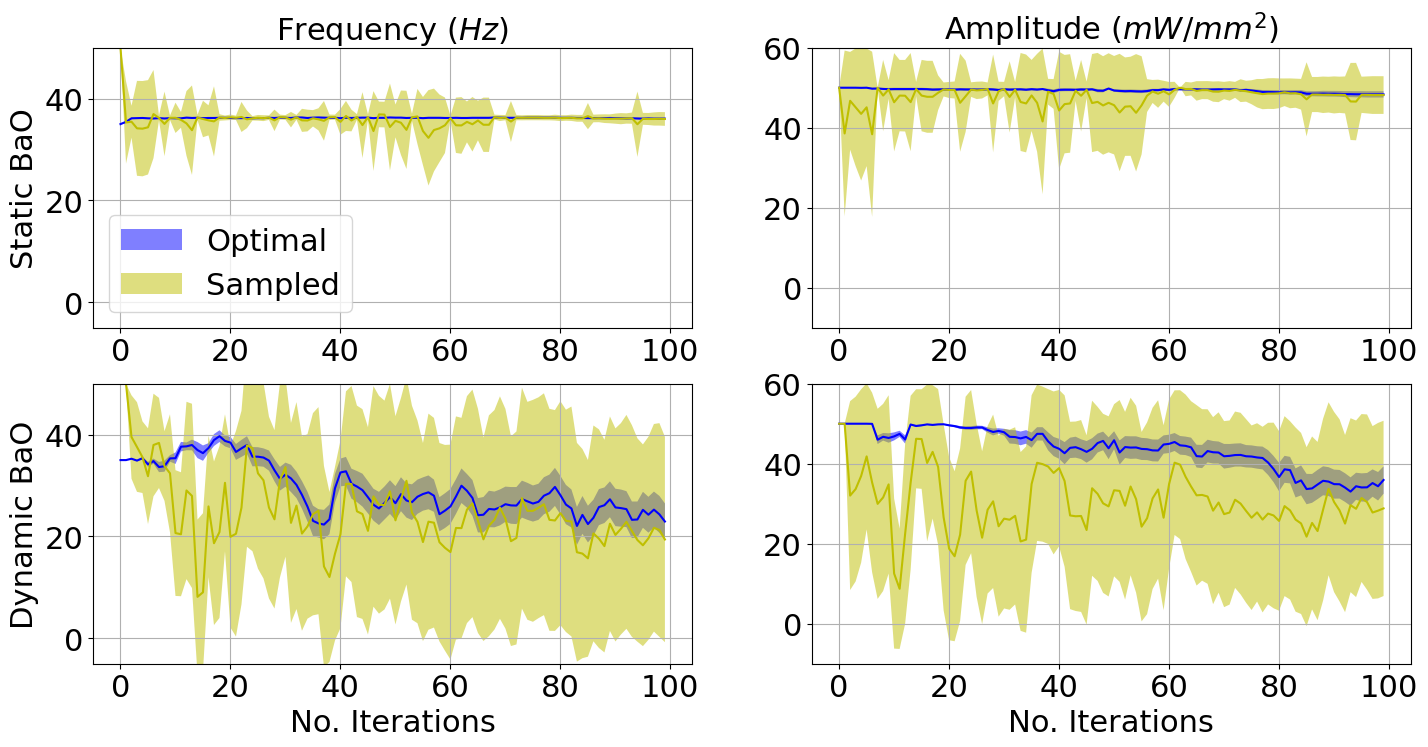

In [134]:
import copy

plot_serr = True
if plot_serr:
    temp_static = copy.copy(static_sample_std)
    temp_dynamic =copy.copy(dynamic_sample_std)
    
    static_sample_std = static_sample_std/np.sqrt(n_exp_runs)
    dynamic_sample_std = dynamic_sample_std/np.sqrt(n_exp_runs)

fsize = 22
plt.rc('font', size = 22)

    
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
fig.title = ("Simulation vs. Static/Dynamic BaO")
plt.subplot(2,2,1)
plt.plot(x_acquisitions, static_sample_mean[:,0], label='__nolabel__', color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,0]+static_sample_std[:,0],
                static_sample_mean[:,0]-static_sample_std[:,0], alpha=0.5, facecolor='b',label = 'Optimal')
plt.plot(x_acquisitions, static_ucb_mean[:,0], label='__nolabel__', color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,0]+static_ucb_std[:,0],
                static_ucb_mean[:,0]-static_ucb_std[:,0], alpha=0.5, facecolor='y',label = 'Sampled')
plt.ylim([-5, 50])
# plt.xlabel("acquisition")
plt.ylabel("Static BaO")
plt.legend()
plt.grid(visible=True)
plt.title('Frequency ($Hz$)',fontsize=fsize)

plt.subplot(2,2,2)
plt.plot(x_acquisitions, static_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,1]+static_sample_std[:,1],
                static_sample_mean[:,1]-static_sample_std[:,1], alpha=0.5, facecolor='b',label = '__nolabel__')
plt.plot(x_acquisitions, static_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,1]+static_ucb_std[:,1],
                static_ucb_mean[:,1]-static_ucb_std[:,1], alpha=0.5, facecolor='y',label = '__nolabel__')
plt.ylim([-10, 60])
# plt.xlabel("acquisition")
# plt.ylabel("Amplitude")
#plt.legend(["Simulation", "Sim Std Dev", "Static", "Static Std Dev"])
plt.grid(visible=True)
plt.title('Amplitude ($mW/mm^2$)',fontsize=fsize)

###
# plt.ylabel('Amplitude ($mW/mm^2$)')
# plt.title('N = 1', fontsize = fsize)

# ax = plt.subplot(2,3,5)
# ax.contourf(X_grid1,X_grid2,np.reshape(pts_to_plot[1],(len(X_grid1),len(X_grid2))))
# plt.xlabel('Frequency ($Hz$)')
###
plt.subplot(2,2,3)
plt.plot(x_acquisitions, dynamic_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,0]+dynamic_sample_std[:,0],
                dynamic_sample_mean[:,0]-dynamic_sample_std[:,0], alpha=0.5, facecolor='b',label = '__nolabel__')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,0]+dynamic_ucb_std[:,0],
                dynamic_ucb_mean[:,0]-dynamic_ucb_std[:,0], alpha=0.5, facecolor='y',label = '__nolabel__')
plt.ylim([-5, 50])
plt.xlabel("No. Iterations")
plt.ylabel("Dynamic BaO")
# plt.legend(["Simulation", "Sim Std Dev", "Dynamic", "Dynamic Std Dev"])

plt.grid(visible=True)

plt.subplot(2,2,4)
plt.plot(x_acquisitions, dynamic_sample_mean[:,1], color='b',label = '__nolabel__')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,1]+dynamic_sample_std[:,1],
                dynamic_sample_mean[:,1]-dynamic_sample_std[:,1], alpha=0.5, facecolor='b',label = 'Optimal')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,1], color='y', label='__nolabel__')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,1]+dynamic_ucb_std[:,1],
                dynamic_ucb_mean[:,1]-dynamic_ucb_std[:,1], alpha=0.5, facecolor='y',label = 'Sampled')
plt.ylim([-10, 60])
plt.xlabel("No. Iterations")
#plt.ylabel("Amplitude")
# plt.legend()
plt.grid(visible=True)

plt.show()

if plot_serr:
    static_sample_std = temp_static
    dynamic_sample_std = temp_dynamic

In [101]:
display(np.shape(static_sample_std))
display(np.shape(static_sample))

(100, 3)

(100, 3, 30)

In [58]:
# calculate mean and std dev for the experiment runs

static_sample_mean = np.mean(static_sample,axis=2)
print(np.shape(static_sample_mean),'\n', static_sample_mean[0:3,:])
dynamic_sample_mean = np.mean(dynamic_sample, axis=2)
static_ucb_mean = np.mean(static_ucb, axis=2)
print(np.shape(static_ucb_mean),'\n', static_ucb_mean[0:3,:])
dynamic_ucb_mean = np.mean(dynamic_ucb, axis=2)

static_sample_std = np.std(static_sample, axis=2)
print(np.shape(static_sample_std),'\n', static_sample_std[0:3,:])
dynamic_sample_std = np.std(dynamic_sample, axis=2)
static_ucb_std = np.std(static_ucb, axis=2)
dynamic_ucb_std = np.std(dynamic_ucb, axis=2)

(100, 3) 
 [[35.         50.          0.81379952]
 [35.33333333 50.          0.91260986]
 [35.9        50.          1.0114202 ]]
(100, 3) 
 [[50.         50.          0.81379952]
 [38.6        30.4         0.91260986]
 [34.4        46.73333333  1.0114202 ]]
(100, 3) 
 [[0.00000000e+00 0.00000000e+00 1.11022302e-16]
 [4.71404521e-01 0.00000000e+00 1.11022302e-16]
 [8.30662386e-01 0.00000000e+00 4.44089210e-16]]


In [145]:
# Std Dev bar plots:
sel_range = False
sr1 = 40; sr2 = 60;

if sel_range:
    std_dev_ucb_df = pd.DataFrame({"Static freq": static_ucb_std[sr1:sr2,0],
                                 "Static amp": static_ucb_std[sr1:sr2,1],
                                 "Dynamic freq": dynamic_ucb_std[sr1:sr2,0],
                                 "Dynamic amp": dynamic_ucb_std[sr1:sr2,1]})
else:
    std_dev_ucb_df = pd.DataFrame({"Static freq": static_ucb_std[:,0],
                                 "Static amp": static_ucb_std[:,1],
                                 "Dynamic freq": dynamic_ucb_std[:,0],
                                 "Dynamic amp": dynamic_ucb_std[:,1]})
display(std_dev_ucb_df.head())
display(np.shape(std_dev_ucb_df))

,Static freq,Static amp,Dynamic freq,Dynamic amp
0,0.000000,0.000000,0.000000,0.000000
1,8.096639,20.724677,0.000000,0.000000
2,3.138294,12.222747,8.192408,23.612826
3,9.320527,14.700000,8.807888,23.098822
4,9.360734,16.656797,7.031753,21.668615


(100, 4)

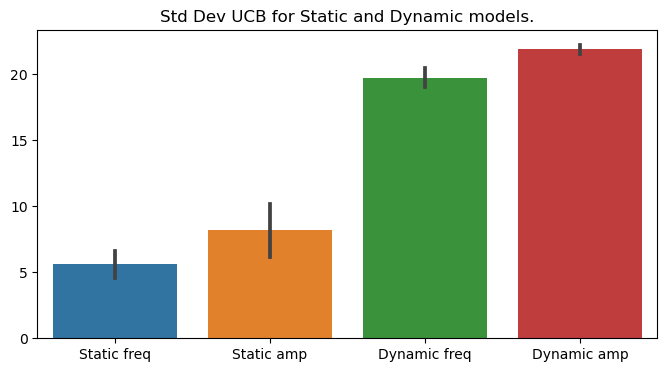

In [70]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_ucb_df); 
plt.title("Std Dev UCB for Static and Dynamic models.");
plt.show();


In [64]:
sel_range = False
sr1 = 40; sr2 = 60;

std_dev_sim_df = pd.DataFrame({"Sim. freq Static": static_sample_std[:,0],
                                 "Sim. amp Static": static_sample_std[:,1],
                                 "Simu. freq Dynamic": dynamic_sample_std[:,0],
                                 "Sim. amp Dynamic": dynamic_sample_std[:,1]})
display(std_dev_sim_df.head())

,Sim. freq Static,Sim. amp Static,Simu. freq Dynamic,Sim. amp Dynamic
0,0.000000,0.0,0.000000,0.0
1,0.471405,0.0,0.000000,0.0
2,0.830662,0.0,0.471405,0.0
3,0.521749,0.0,0.774597,0.0
4,0.453382,0.0,1.087811,0.0


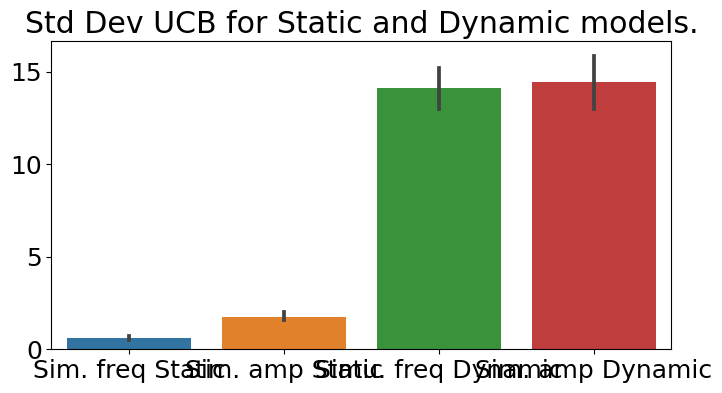

In [143]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_sim_df); 
plt.title("Std Dev UCB for Static and Dynamic models.");
plt.show();


In [138]:
# Std Dev bar plots:
sel_range = True
sr1 = 40; sr2 = 60;

if sel_range:
    mean_opt_df = pd.DataFrame({"Static freq": static_sample_mean[sr1:sr2,0],
                                 "Static amp": static_sample_mean[sr1:sr2,1],
                                 "Dynamic freq": dynamic_sample_mean[sr1:sr2,0],
                                 "Dynamic amp": dynamic_sample_mean[sr1:sr2,1]})
else:
    mean_opt_df = pd.DataFrame({"Static freq": static_sample_mean[:,0],
                                 "Static amp": static_sample_mean[:,1],
                                 "Dynamic freq": dynamic_sample_mean[:,0],
                                 "Dynamic amp": dynamic_sample_mean[:,1]})
display(std_dev_ucb_df.head())
display(np.shape(std_dev_ucb_df))

,Static freq,Static amp,Dynamic freq,Dynamic amp
0,36.166667,49.466667,32.566667,43.733333
1,36.233333,49.500000,32.800000,42.633333
2,36.200000,49.500000,30.366667,43.966667
3,36.233333,49.466667,29.800000,44.133333
4,36.266667,49.566667,29.100000,43.633333


(20, 4)

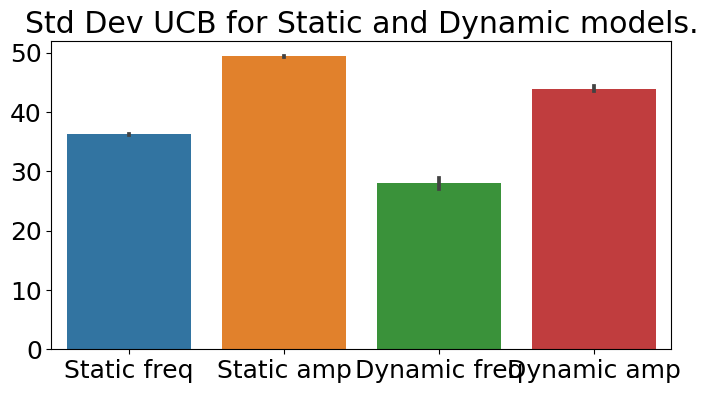

In [149]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_opt_df); 
plt.title("Std Dev UCB for Static and Dynamic models.");
plt.show();


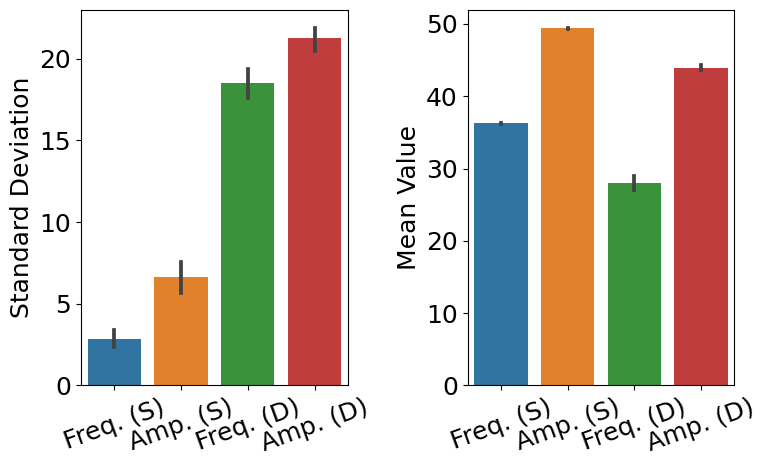

In [156]:
plt.rc('font',size = 18)
x_labels = ['Freq. (S)','Amp. (S)','Freq. (D)','Amp. (D)']

fig = plt.figure(figsize=(8,5));
plt.subplot(1,2,1)
plt.xticks(rotation=20)
bplot = sns.barplot(data=std_dev_ucb_df); 
plt.ylabel('Standard Deviation')
bplot.set_xticklabels(x_labels)
plt.subplot(1,2,2)

bplot = sns.barplot(data=mean_opt_df); 
plt.xticks(rotation=20)
bplot.set_xticklabels(x_labels)
plt.ylabel('Mean Value')
fig.tight_layout()
plt.show()



#### 1.6 Comparing Models and Acquisition Functions optimum freq and amp to stimulate at

In [508]:
derivative_static_freq = np.gradient(static_ucb_mean[:,0])
idx_derivative_satic_freq = np.where(derivative_static_freq==0)
print("The derivative of Static Freq is: ", derivative_static_freq, "\n index where static freq plateaus: ", idx_derivative_satic_freq)

derivative_static_amp = np.gradient(static_ucb_mean[:,1])
idx_derivative_satic_amp = np.where(derivative_static_amp==0)
print("The derivative of Static Amp is: ", derivative_static_amp, "\n index where static freq plateaus: ", idx_derivative_satic_amp)

idx_plateau_static_freq = []
idx_plateau_static_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_static_freq[p:p+1]==0. :
        idx_plateau_static_freq = np.append(idx_plateau_static_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_static_amp[p:p+1]==0. :
        idx_plateau_static_amp = np.append(idx_plateau_static_amp,[p+1])
        
print("The idx of first plateau for static model with length 2 sample for freq is: ", idx_plateau_static_freq[0]) 
print("The idx of first plateau static model with length 2 sample for amp is: ", idx_plateau_static_amp[0]) 

The derivative of Static Freq is:  [-13.93333333  -7.56666667  -0.63333333   0.71666667  -0.68333333
   0.08333333   0.71666667   0.08333333   0.58333333  -0.46666667
   0.15         0.13333333   0.           0.18333333  -0.26666667
   0.           0.08333333  -0.28333333   0.08333333   0.33333333
  -0.45        -0.15        -0.28333333   0.03333333   0.21666667
   0.06666667   0.38333333  -0.46666667   0.11666667   0.55
  -0.51666667  -1.46666667   0.58333333   1.41666667  -0.3
  -0.7          0.25         0.1          0.25         0.05
  -1.18333333  -0.5          0.35         0.23333333   0.65
   0.38333333  -1.2         -0.26666667  -0.98333333  -2.75
   1.13333333   2.4          0.18333333  -1.           0.36666667
   1.31666667   0.6          0.36666667  -0.76666667  -0.26666667
   0.4         -0.35        -0.51666667  -0.03333333  -0.18333333
   1.08333333   1.28333333  -0.33333333  -0.56666667  -0.06666667
  -0.36666667  -0.66666667   0.28333333   0.66666667   0.08333333
  -0.0

In [509]:
derivative_dynamic_freq = np.gradient(dynamic_ucb_mean[:,0])
idx_derivative_dynamic_freq = np.where(derivative_dynamic_freq==0)
print("The derivative of dynamic Freq is: ", derivative_dynamic_freq, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_freq)

derivative_dynamic_amp = np.gradient(dynamic_ucb_mean[:,1])
idx_derivative_dynamic_amp = np.where(derivative_dynamic_amp==0)
print("The derivative of dynamic Amp is: ", derivative_dynamic_amp, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_amp)

idx_plateau_dynamic_freq = []
idx_plateau_dynamic_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_dynamic_freq[p:p+1]==0. :
        idx_plateau_dynamic_freq = np.append(idx_plateau_dynamic_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_dynamic_amp[p:p+1]==0. :
        idx_plateau_dynamic_amp = np.append(idx_plateau_dynamic_amp,[p+1])
        
print("The idx of first plateau for dynamic model with length 2 sample for freq is: ", idx_plateau_dynamic_freq[0]) 
print("The idx of first plateau dynamic model with length 2 sample for amp is: ", idx_plateau_dynamic_amp[0]) 

The derivative of dynamic Freq is:  [  0.          -4.53333333  -6.75        -2.85        -1.45
   2.1          2.95        -3.1         -5.21666667  -7.13333333
  -6.23333333   4.18333333   7.45        -9.9        -12.46666667
   9.45         4.86666667  -4.41666667   5.93333333  -1.38333333
  -3.45         8.91666667   7.36666667   3.31666667  -1.08333333
  -4.          -2.73333333  -3.43333333   0.48333333   3.35
  -4.3         -6.55        -1.93333333  -1.38333333   0.25
   0.56666667  -5.1         -2.98333333   3.63333333   5.35
   5.2          2.03333333  -2.36666667  -1.98333333   2.3
   4.15         2.38333333  -1.06666667  -1.48333333  -1.68333333
  -2.85        -0.86666667   1.31666667  -0.55        -3.21666667
  -3.41666667  -0.4          4.41666667   2.5         -5.98333333
  -3.41666667   4.35         2.9          2.1          1.
  -3.41666667  -0.51666667   1.85         3.68333333   2.96666667
  -2.33333333  -2.26666667  -0.5          0.65         0.38333333
   0.01666667

In [510]:
idx_static_vs_dynamic_freq = idx_plateau_dynamic_freq[0] - idx_plateau_static_freq[0]
idx_static_vs_dynamic_amp = idx_plateau_dynamic_amp[0] - idx_plateau_static_amp[0]

print("the dynamic freq plateaus at sample %d after the static sample.", idx_static_vs_dynamic_freq)
print("the dynamic amp plateaus at sample %d after the static sample.", idx_static_vs_dynamic_amp)

the dynamic freq plateaus at sample %d after the static sample. -12.0
the dynamic amp plateaus at sample %d after the static sample. -4.0


#### 1.5.2: Comparing the Simulation with Static/Dynamic models using Normalized Mean-Squared-Error (NMSE).

$$NMSE(GP_{est}, GP_{sim})= \frac{||\mu_{est}(x)-\mu_{sim}(s)||_2^2}{||\mu_{sim}(x)||_2^2} $$

In [511]:
nmse_static_simulatinon_freq = np.square(np.subtract(static_ucb_mean[:,0], static_sample_mean[:, 0])).mean()/(np.square(static_sample_mean[:, 0])).mean()
nmse_static_simulatinon_freq = np.round(nmse_static_simulatinon_freq, 4)
print("nmse_static_simulatinon_freq: ", nmse_static_simulatinon_freq)
nmse_static_simulatinon_amp = np.square(np.subtract(static_ucb_mean[:,1], static_sample_mean[:, 1])).mean()/(np.square(static_sample_mean[:, 1])).mean()
nmse_static_simulatinon_amp = np.round(nmse_static_simulatinon_amp, 4)
print("nmse_static_simulatinon_amp: ", nmse_static_simulatinon_amp, '\n')

nmse_dynamic_simulatinon_freq = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 0])).mean()/(np.square(dynamic_sample_mean[:, 0])).mean()
nmse_dynamic_simulatinon_freq = np.round(nmse_dynamic_simulatinon_freq, 4)
print("nmse_dynamic_simulatinon_freq: ", nmse_dynamic_simulatinon_freq)
nmse_dynamic_simulatinon_amp = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 1])).mean()/(np.square(dynamic_sample_mean[:, 1])).mean()
nmse_dynamic_simulatinon_amp = np.round(nmse_dynamic_simulatinon_amp, 4)
print("nmse_dynamic_simulatinon_amp: ", nmse_dynamic_simulatinon_amp)

nmse_static_simulatinon_freq:  0.0031
nmse_static_simulatinon_amp:  0.0031 

nmse_dynamic_simulatinon_freq:  0.0869
nmse_dynamic_simulatinon_amp:  0.1913


In [512]:
print(np.shape(ucb_sample))

(100, 3)


x_BaO, y_BaO, trained_model_BaO = model.bayes_opt_update_state(trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, 
                                                               ker_BaO, slice_dim, ylabel, initialize_data_dr_sim)

# initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

### Acquisition Function pseudo code and draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end